# Setup (install & imports)

In [1]:
!pip -q install scikit-learn matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit



#1) Load the data

In [16]:
# The MNIST files were downloaded to /tmp/train.csv and /tmp/test.csv by a previous cell (cell `aa38a69d`).
# You can now load the data from these local paths.

# Original URLs (for reference):
# train_url = "https://drive.google.com/uc?id=1aWbBppfbK3oK1he7U5ASbLFi6WIPAlFh"
# test_url  = "https://drive.google.com/uc?id=1-uz59TYoTCJS0irJdEvpOlhpQPMlOpbZ"

In [19]:
from google.colab import files
uploaded = files.upload()

#2) Inspect the raw CSVs (shape & sample rows)

In [33]:
import pandas as pd

# After upload, Colab saves them in the current directory:
TRAIN_CSV = "MNIST_train.csv"
TEST_CSV  = "MNIST_test.csv"

train_df_raw = pd.read_csv(TRAIN_CSV)
test_df_raw  = pd.read_csv(TEST_CSV)

print("Train shape:", train_df_raw.shape)
print("Test shape:",  test_df_raw.shape)

display(train_df_raw.head())
display(test_df_raw.head())


Train shape: (60000, 787)
Test shape: (10000, 787)


,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#3) Clean & preprocess (drop extras, split X/y, normalize)

In [22]:
def guess_label_column(df: pd.DataFrame):
    # Simple heuristic: look for a column named 'label' or 'labels'
    for col in ["label", "labels"]:
        if col in df.columns:
            return col
    return None

def clean_and_split(train_df: pd.DataFrame, test_df: pd.DataFrame, target_col: str=None):
    # Drop redundant index columns if present
    for df in (train_df, test_df):
        for col in ["Unnamed: 0", "index"]:
            if col in df.columns:
                df.drop(columns=[col], inplace=True)

    # Resolve label column
    tcol = target_col or guess_label_column(train_df)
    if tcol is None:
        raise ValueError("Could not find the label column automatically. Please set TARGET_COL manually.")

    # Split train
    y_train = train_df[tcol].astype(int).values
    X_train = train_df.drop(columns=[tcol]).astype("float32").values

    # Does test have the label?
    has_test_label = tcol in test_df.columns

    if has_test_label:
        y_test = test_df[tcol].astype(int).values
        X_test = test_df.drop(columns=[tcol]).astype("float32").values
    else:
        y_test = None
        X_test = test_df.astype("float32").values

    # Normalize
    X_train /= 255.0
    X_test  /= 255.0

    return X_train, y_train, X_test, y_test, tcol, has_test_label

X_train, y_train, X_test, y_test, TARGET_COL, TEST_HAS_LABEL = clean_and_split(
    train_df_raw.copy(), test_df_raw.copy()
)

print(f"Label column: {TARGET_COL} | Test has label? {TEST_HAS_LABEL}")
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test:  X={X_test.shape},  y={'None' if y_test is None else y_test.shape}")

Label column: labels | Test has label? True
Train: X=(60000, 784), y=(60000,)
Test:  X=(10000, 784),  y=(10000,)


#4) (Optional) Visualize a few digits to sanity-check

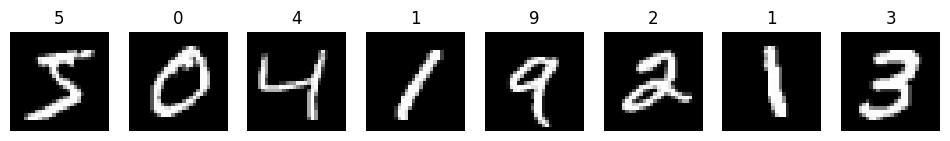

In [23]:
def show_digits(X, y, n=8):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap="gray")
        plt.title(int(y[i]))
        plt.axis("off")
    plt.show()

show_digits(X_train, y_train, n=8)


#5)Baseline model — Gaussian Naive Bayes

In [24]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)
acc_gnb = accuracy_score(y_test, y_pred_gnb)

print(f"Gaussian Naive Bayes Accuracy: {acc_gnb:.4f}")
print("\nClassification report (GNB):")
print(classification_report(y_test, y_pred_gnb, digits=4))


Gaussian Naive Bayes Accuracy: 0.5558

Classification report (GNB):
              precision    recall  f1-score   support

           0     0.7902    0.8878    0.8361       980
           1     0.8456    0.9507    0.8951      1135
           2     0.9048    0.2578    0.4012      1032
           3     0.7088    0.3495    0.4682      1010
           4     0.8842    0.1711    0.2867       982
           5     0.5500    0.0493    0.0905       892
           6     0.6500    0.9342    0.7666       958
           7     0.8777    0.2724    0.4157      1028
           8     0.2842    0.6653    0.3983       974
           9     0.3694    0.9465    0.5314      1009

    accuracy                         0.5558     10000
   macro avg     0.6865    0.5484    0.5090     10000
weighted avg     0.6917    0.5558    0.5170     10000



#6) Confusion matrix for Naive Bayes

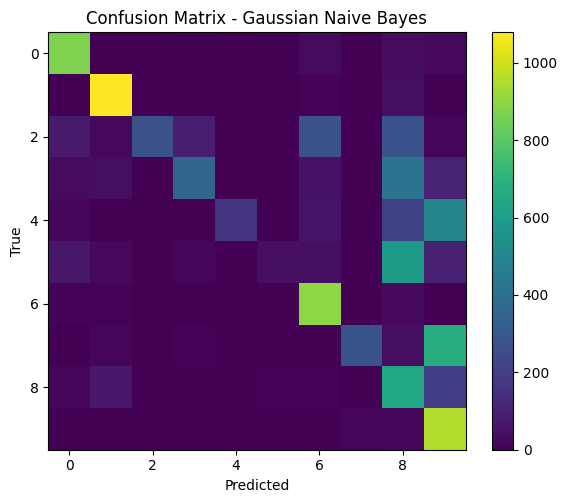

In [25]:
cm_gnb = confusion_matrix(y_test, y_pred_gnb)

plt.figure(figsize=(6,5))
plt.imshow(cm_gnb)
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()


#7) KNN with optional PCA (configurable & scalable)

In [26]:
# Configuration: adjust for speed/accuracy
KNN_K = 3
KNN_TRAIN_SUBSET = 5000      # None = use all 60k (can be slow on Colab)
USE_PCA = True
PCA_N_COMPONENTS = 30        # try 50 for higher accuracy
RANDOM_STATE = 42

def stratified_subset(X, y, n_samples, random_state=42):
    if (n_samples is None) or (n_samples >= len(y)):
        return X, y
    sss = StratifiedShuffleSplit(n_splits=1, test_size=len(y)-n_samples, random_state=random_state)
    keep_idx, _ = next(sss.split(np.arange(len(y)), y))
    return X[keep_idx], y[keep_idx]

def make_knn_pipeline(use_pca=True, pca_components=30, k=3):
    steps = []
    steps.append(("scaler", StandardScaler(with_mean=False)))
    if use_pca:
        steps.append(("pca", PCA(n_components=pca_components, whiten=True, random_state=RANDOM_STATE)))
    steps.append(("knn", KNeighborsClassifier(n_neighbors=k, weights="distance")))
    return Pipeline(steps)

# Take subset (or full data)
X_train_sub, y_train_sub = stratified_subset(X_train, y_train, KNN_TRAIN_SUBSET, RANDOM_STATE)
print("KNN training subset:", X_train_sub.shape, y_train_sub.shape)

# Fit pipeline
knn_pipe = make_knn_pipeline(use_pca=USE_PCA, pca_components=PCA_N_COMPONENTS, k=KNN_K)
knn_pipe.fit(X_train_sub, y_train_sub)

# Predict on full test set
y_pred_knn = knn_pipe.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

print(f"KNN (k={KNN_K}, PCA={USE_PCA}, comps={PCA_N_COMPONENTS if USE_PCA else 'N/A'}) Accuracy: {acc_knn:.4f}")
print("\nClassification report (KNN):")
print(classification_report(y_test, y_pred_knn, digits=4))


KNN training subset: (5000, 784) (5000,)
KNN (k=3, PCA=True, comps=30) Accuracy: 0.9122

Classification report (KNN):
              precision    recall  f1-score   support

           0     0.9632    0.9602    0.9617       980
           1     0.9542    0.9903    0.9719      1135
           2     0.9450    0.8983    0.9210      1032
           3     0.8737    0.8901    0.8818      1010
           4     0.9269    0.8910    0.9086       982
           5     0.8852    0.8643    0.8746       892
           6     0.9415    0.9572    0.9493       958
           7     0.9262    0.8911    0.9083      1028
           8     0.8596    0.8676    0.8636       974
           9     0.8445    0.8989    0.8709      1009

    accuracy                         0.9122     10000
   macro avg     0.9120    0.9109    0.9112     10000
weighted avg     0.9128    0.9122    0.9122     10000



#8) Confusion matrix for KNN

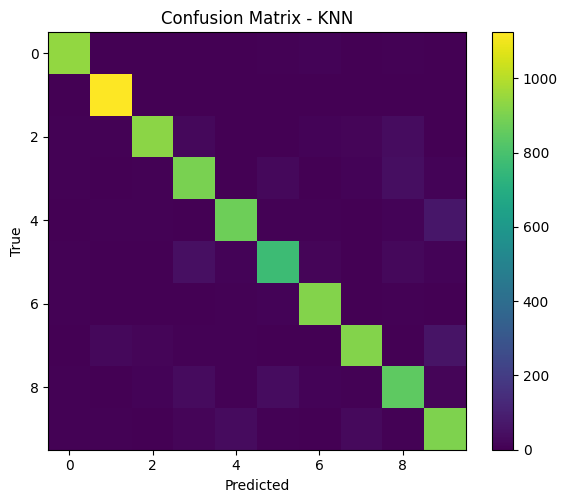

In [27]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(6,5))
plt.imshow(cm_knn)
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()


#9) Quick hyperparameter tryouts

In [28]:
# Try a few k values quickly (on the same subset) to see impact
for k in [3, 5, 7]:
    pipe = make_knn_pipeline(use_pca=USE_PCA, pca_components=PCA_N_COMPONENTS, k=k)
    pipe.fit(X_train_sub, y_train_sub)
    preds = pipe.predict(X_test)
    print(f"k={k} -> Accuracy: {accuracy_score(y_test, preds):.4f}")


k=3 -> Accuracy: 0.9122
k=5 -> Accuracy: 0.9136
k=7 -> Accuracy: 0.9133


#10) Save predictions to CSV (handy for reports/submit)

In [31]:
os.makedirs("mnist_outputs", exist_ok=True)
pd.DataFrame({"prediction": y_pred_gnb}).to_csv("mnist_outputs/predictions_gnb.csv", index=False)
pd.DataFrame({"prediction": y_pred_knn}).to_csv("mnist_outputs/predictions_knn.csv", index=False)
print("Saved to mnist_outputs/predictions_gnb.csv and mnist_outputs/predictions_knn.csv")


Saved to mnist_outputs/predictions_gnb.csv and mnist_outputs/predictions_knn.csv


In [32]:
from google.colab import files

files.download("mnist_outputs/predictions_gnb.csv")
files.download("mnist_outputs/predictions_knn.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>